# WOE Visualization: Feature-Level and Prediction-Level

This notebook demonstrates the `visualize_woe` function for both:

1. **Feature-level visualization**: Showing WOE values for categories within a single feature
2. **Prediction-level visualization**: Showing feature contributions to a specific prediction

Both modes support probability (proba) and logit display.


In [1]:
import numpy as np
import pandas as pd

from fastwoe import FastWoe, WeightOfEvidence
from fastwoe.plots import visualize_woe

## Create Sample Data

We'll create a dataset with categorical features to demonstrate WOE visualization.


In [2]:
# Create sample data
n_samples = 1000

data = {
    "channel": np.random.choice(
        ["Online", "Branch", "Phone", "Mobile"], n_samples, p=[0.4, 0.3, 0.2, 0.1]
    ),
    "card_usage": np.random.choice(["< 50%", "50-80%", "> 80%"], n_samples, p=[0.3, 0.4, 0.3]),
    "region": np.random.choice(["North", "South", "East", "West"], n_samples),
    "product_type": np.random.choice(
        ["Standard", "Premium", "Basic"], n_samples, p=[0.5, 0.3, 0.2]
    ),
}

X = pd.DataFrame(data)

# Create target with some relationship to features
y = np.zeros(n_samples)
for i in range(n_samples):
    prob = 0.04  # Base default rate
    if X.iloc[i]["channel"] == "Online":
        prob += 0.05
    if X.iloc[i]["card_usage"] == "< 50%":
        prob -= 0.01
    if X.iloc[i]["region"] == "North":
        prob += 0.02
    y[i] = np.random.binomial(1, prob)

print(f"Dataset shape: {X.shape}")
print(f"Default rate: {y.mean():.2%}")
print("\nFeatures:")
print(X.head())

Dataset shape: (1000, 4)
Default rate: 5.90%

Features:
  channel card_usage region product_type
0  Online      < 50%   East      Premium
1  Mobile     50-80%  South     Standard
2  Branch     50-80%   West        Basic
3  Branch     50-80%  South     Standard
4  Branch     50-80%   East     Standard


## Fit FastWoe Encoder


In [3]:
# Fit FastWoe encoder
encoder = FastWoe()
encoder.fit(X, y)

print("Encoder fitted successfully!")
print(f"Features encoded: {list(encoder.get_all_mappings().keys())}")

Encoder fitted successfully!
Features encoded: ['channel', 'card_usage', 'region', 'product_type']


## 1. Feature-Level Visualization

Visualize WOE values for individual features. This shows how different categories within a feature affect the target.

### Channel Feature (Probability/Proba Mode)


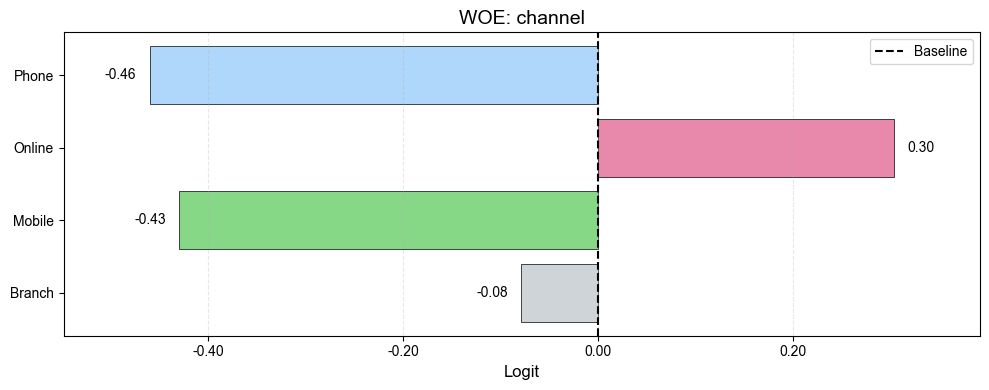


WOE Data:
  category       woe     logit  logit_delta
0   Branch -0.078406 -2.847812    -0.078406
1   Mobile -0.429267 -3.198673    -0.429267
2   Online  0.303496 -2.465910     0.303496
3    Phone -0.459420 -3.228826    -0.459420


In [4]:
# Visualize channel feature in probability mode
result = visualize_woe(
    encoder, feature_name="channel", mode="logit", figsize=(10, 4), show_plot=True
)

print("\nWOE Data:")
print(result)

### Card Usage Feature (Probability/Proba Mode)


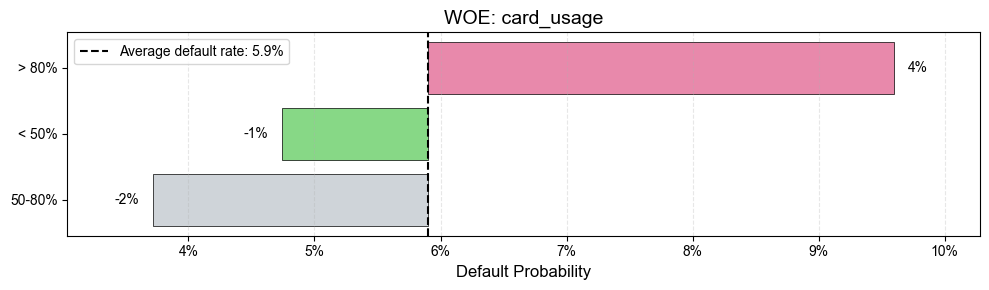


WOE Data:
  category       woe     proba  proba_delta
0   50-80% -0.483549  0.037221    -0.021779
1    < 50% -0.230165  0.047445    -0.011555
2    > 80%  0.526639  0.095975     0.036975


In [5]:
# Visualize card_usage feature
result = visualize_woe(
    encoder, feature_name="card_usage", mode="proba", figsize=(10, 3), show_plot=True
)

print("\nWOE Data:")
print(result)

### Channel Feature (Logit Mode)


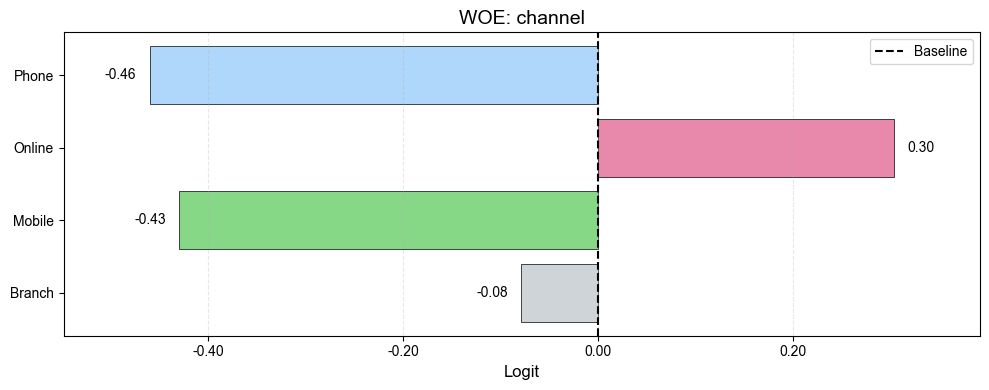


WOE Data:
  category       woe     logit  logit_delta
0   Branch -0.078406 -2.847812    -0.078406
1   Mobile -0.429267 -3.198673    -0.429267
2   Online  0.303496 -2.465910     0.303496
3    Phone -0.459420 -3.228826    -0.459420


In [6]:
# Visualize channel feature in logit mode
result = visualize_woe(
    encoder, feature_name="channel", mode="logit", figsize=(10, 4), show_plot=True
)

print("\nWOE Data:")
print(result)

## 2. Prediction-Level Visualization

Visualize feature contributions for a specific prediction. This shows how each feature contributes to the final prediction for a single sample.

### Create WeightOfEvidence Explainer


In [7]:
# Create explainer
explainer = WeightOfEvidence(encoder, X, y)

print("Explainer created successfully!")

Explainer created successfully!


### Get Explanation for a Sample


In [8]:
# Select a sample to explain
sample_idx = 0
sample = X.iloc[sample_idx]

print(f"Sample to explain (index {sample_idx}):")
print(sample)
print(f"\nTrue label: {y[sample_idx]}")

# Get explanation
explanation = explainer.explain(sample, return_dict=True)

print(f"\nPredicted label: {explanation['predicted_label']}")
print(f"Total WOE: {explanation['total_woe']:.3f}")
print(f"Interpretation: {explanation['interpretation']}")
print("\nFeature contributions:")
for feature, woe_val in explanation["feature_contributions"].items():
    print(f"  {feature}: {woe_val:.3f}")

Sample to explain (index 0):
channel          Online
card_usage        < 50%
region             East
product_type    Premium
Name: 0, dtype: object

True label: 0.0

Predicted label: Negative
Total WOE: -0.388
Interpretation: Weak evidence AGAINST the hypothesis

Feature contributions:
  channel: 0.303
  card_usage: -0.230
  region: -0.404
  product_type: -0.056


### Visualize Feature Contributions (Probability/Proba Mode)


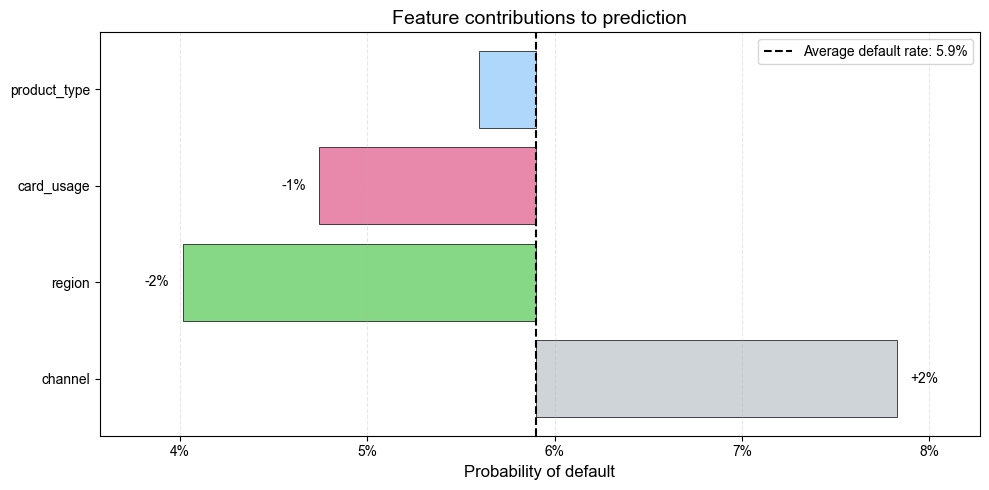


Feature Contribution Data:
        feature       woe     proba  proba_delta
0       channel  0.303496  0.078283     0.019283
2        region -0.404473  0.040161    -0.018839
1    card_usage -0.230165  0.047445    -0.011555
3  product_type -0.056428  0.055944    -0.003056


In [9]:
# Visualize feature contributions in probability mode
result = visualize_woe(
    encoder, explanation=explanation, mode="proba", figsize=(10, 5), show_plot=True
)

print("\nFeature Contribution Data:")
print(result)

### Visualize Feature Contributions (Logit Mode)


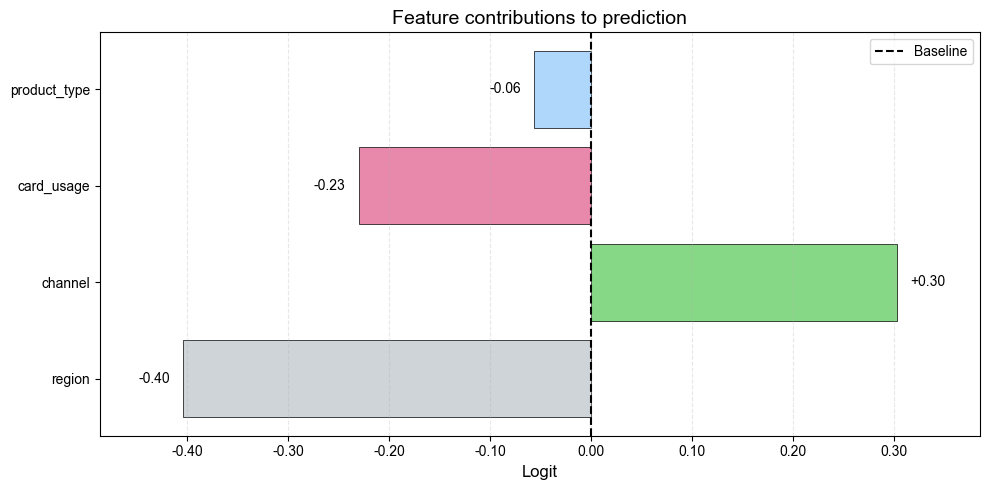


Feature Contribution Data:
        feature       woe     logit  logit_delta
2        region -0.404473 -3.173878    -0.404473
0       channel  0.303496 -2.465910     0.303496
1    card_usage -0.230165 -2.999571    -0.230165
3  product_type -0.056428 -2.825833    -0.056428


In [10]:
# Visualize feature contributions in logit mode
result = visualize_woe(
    encoder, explanation=explanation, mode="logit", figsize=(10, 5), show_plot=True
)

print("\nFeature Contribution Data:")
print(result)